<a href="https://colab.research.google.com/github/ymiftah/aut/blob/master/Classic_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classic Control Problems

Keywords: optimal control, path planning, ipopt usage

On this notebook we will explore the classic control problem that are part of the gym library for reinforcement learning.

These problems are good playground for testing reinforcement learning algorithms, and I will create another notebook studying that angle. In this notebook however I will apply classic control theory techniques.

## Dependencies installation

In [0]:
# Rendering Dependancies
!pip install -qq gym pyvirtualdisplay
!apt-get install -y -qq xvfb python-opengl ffmpeg

!apt-get update -qq
!apt-get install -qq cmake
!pip install --upgrade -qq setuptools
!pip install -qq ez_setup

from gym.wrappers import Monitor
from IPython.display import HTML
import glob
import io
import base64

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Selecting previously unselected package python-opengl.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

     |████████████████████████████████| 2.4MB 108kB/s 
     |████████████████████████████████| 256kB 50.7MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 163kB 45.3MB/s 


In [0]:
import gym

def show_video(folder):
    mp4list = glob.glob(folder+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

def wrap_env(env, folder='./video'):
    env = Monitor(env, folder, force=True)
    return env


def play(env, agent):
    observation = env.reset()
    reward = 0
    counter = 0
    done = False

    while True:
        counter += 1
        env.render()
        
        #your agent goes here
        action = agent.act(observation, reward, done) 
            
        observation, reward, done, info = env.step(action)

        if done:
            print('Total steps taken : ', counter)
            print(info)
            break;
                
    env.close()

## Mountain Car v0

The mountain car environment requires a car to go uphill to its target. It is however limited by the torque of the motor driving it, so the only way for the car to get to the target is to gain momentum my going uphill-downhill in succession.


<img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCar-v0/poster.jpg" width="300rem" alt="mountaincar-gym">

The system dynamics implemented in gym are actually quite simple :

$$ \ddot{x} = F - g  \cos(3*x) $$

In this case a direct optimization approach is possible : we will formulate the control problem as a non linear optimization problem and use the open source ipopt solver to define the controls at each time steps to drive the car to the flag.

### Pyomo model

#### Model

In [0]:
def traj(start=-.5):
    # create a model object
    m = ConcreteModel()

    # parameters
    min_position = -1
    max_position = 0.6
    max_speed = 0.068
    goal_position = 0.6
    goal_velocity = 0

    F = 0.0015
    g = 0.0025

    # time and length scales
    tf = 200

    # define the independent variable
    m.t = RangeSet(tf)
    m.t_ = RangeSet(tf-1)

    # define control inputs
    m.u = Var(m.t, domain=Reals, bounds=(-1, 1))

    # define the dependent variables
    m.x = Var(m.t, domain=Reals, bounds=(-1.2, 0.6))
    m.v = Var(m.t, domain=Reals, bounds=(-0.07, 0.07))

    # define the differential equation as constrainta
    m.ode_x = Constraint(m.t_, rule=lambda m, t: m.x[t+1] == m.x[t] + m.v[t+1])
    m.ode_v = Constraint(m.t_, rule=lambda m, t: m.v[t+1] == m.v[t] + F * m.u[t] - g * cos(3*m.x[t]))

    # initial conditions
    m.pc = ConstraintList()
    m.pc.add(m.x[1] == start)
    m.pc.add(m.v[1] == 0)

    # final conditions
    m.pc.add(m.x[tf] == goal_position)
    m.pc.add(m.v[tf] == goal_velocity)

    # final conditions on the control inputs
    #m.pc.add(m.u[1] == 0)
    m.pc.add(m.u[tf] == 0)

    # define the optimization objective
    m.obj = Objective(expr=sum(m.u[t]**2 
                            for t in m.t))

    # transform and solve
    # TransformationFactory('dae.collocation').apply_to(m, wrt=m.t, nfe=20, ncp=6,
    #                                                   scheme='LAGRANGE-RADAU')
    SolverFactory('ipopt').solve(m)
    return m, np.array([m.u[t]() for t in m.t])

#### Solve and visualize path

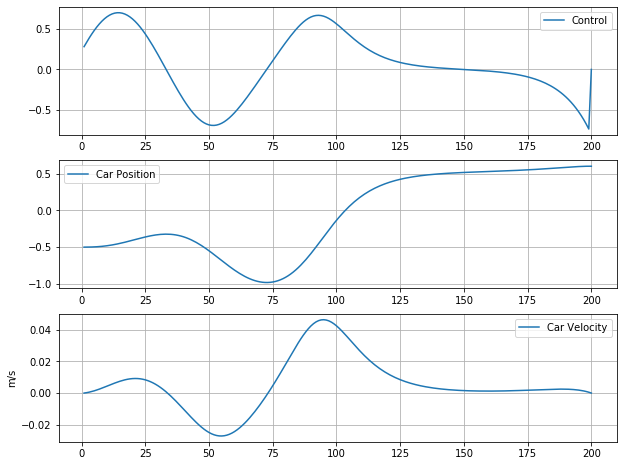

In [0]:
m, _ = traj()

# access the results
t = np.array([t for t in m.t])

u = np.array([m.u[t]() for t in m.t])

x = np.array([m.x[t]() for t in m.t])
v = np.array([m.v[t]() for t in m.t])

def plot_results(t, x, v, u):
    fig, ax = plt.subplots(3,1, figsize=(10,8))

    ax[0].plot(t, u)
    ax[0].legend(['Control'])

    ax[1].plot(t, x)
    ax[1].legend(['Car Position'])

    ax[2].plot(t, v)
    ax[2].legend(['Car Velocity'])
    ax[2].set_ylabel('m/s')
    for axes in ax:
        axes.grid(True)
        
plot_results(t, x, v, u)

### Visualizing the car path

In [0]:
env = wrap_env(gym.make('MountainCarContinuous-v0'), folder='./video')
observation = env.reset()
m, u = traj(observation[0])
reward = 0
counter = 0
done = False

positions = [observation[0]]
velo = [observation[1]]

while True:
    env.render()
    try:
        action = [u[counter]]
        observation, reward, done, info = env.step(action)
        positions.append(observation[0])
        velo.append(observation[1])
    except:
        #env.action_space.sample()
        done = True

    if done:
        print('Total steps taken : ', counter)
        break;
    counter += 1
            
env.close()

show_video(folder='./video')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total steps taken :  162


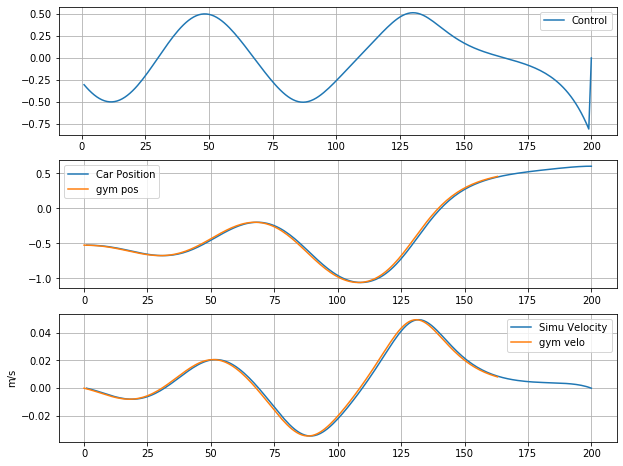

In [0]:
# access the results
t = np.array([t for t in m.t])

u = np.array([m.u[t]() for t in m.t])

x = np.array([m.x[t]() for t in m.t])
v = np.array([m.v[t]() for t in m.t])


fig, ax = plt.subplots(3,1, figsize=(10,8))

ax[0].plot(t, u)
ax[0].legend(['Control'])

ax[1].plot(t, x, range(len(positions)), positions)
ax[1].legend(['Car Position', 'gym pos'])

ax[2].plot(t, v, range(len(positions)), velo)
ax[2].legend(['Simu Velocity', 'gym velo'])
ax[2].set_ylabel('m/s')
for axes in ax:
    axes.grid(True)


## Pendulum

The pendulum is a simple system : a beam of known mass and length attached to a pivot. A motor can exert a torque at the pivot to move the pendulum.

<img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/Pendulum-v0/poster.jpg" width="300rem" alt="pendulum-gym">

The system dynamics as implemented in gym are as follow

$$ \ddot{\theta} = \frac{3}{ml^2} u - \frac{3 g}{2*l} \sin(\theta) $$

Here we will use two techniques :
- Energy shaping to bring the pole close to the upright position, by increasing the energy of the system.
- Linear Feedback control to keep the pole at upright position, through pole placement of the linearized dynamics around the upright equilibrium position.


### Feedback controller

In [0]:
from scipy.signal import place_poles

g, m, l = 10, 1, 1
k = 2
A = np.array([[        0, 1],
              [3/(2*g*l), 0]])
B = np.array([0, 3/(2*m*g*l**2)])
r = place_poles(A,B.reshape(2,1),[-4.1,-4.02]).gain_matrix.flatten()

def controller(tth, thdot):
    th = tth % (2*np.pi)
    th = th if th < np.pi else th - 2*np.pi
    if abs(th) < np.pi/6:
        return - np.dot(r, np.array([th, thdot]))
    else:
        E = .5 * m * l**2 * thdot**2 + m*g*l*np.cos(th)
        Ed = m*g*l

        return - k * thdot * (E-Ed)

In [0]:
env = wrap_env(gym.make('Pendulum-v0'), folder='./video')
observation = env.reset()
reward = 0
counter = 0
done = False

while True:
    state = env.state
    #print(state)
    u = controller(*state)
    observation, reward, done, info = env.step([u])
    env.render()

    if done or counter > 500:
        print('Total steps taken : ', counter)
        break
    counter += 1
            
env.close()

show_video(folder='./video')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total steps taken :  199


## Cart Pole

The cartpole problem is a classical problem of control theory.
The goal is to find the right controls for the cart such that the inverted pendulum stays in a stable upright position.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Cart-pendulum.svg/300px-Cart-pendulum.svg.png>




### System dynamics
We remind below the equations ruling the dynamics of the cartpole system (frictionless), and which are implemented on OpenAI CartPole environment.

$$ \ddot{x} = \frac{F+m_p l\ [\sin(\theta)\ \dot{\theta}^2- \cos(\theta) \ddot{\theta}]}{M} $$

$$
\ddot{\theta}=
\frac{g\sin(\theta) - \frac{F}{M}\cos(\theta) - \frac{m_p}{M}l \cos(\theta)\sin(\theta)\dot{\theta}^2}{l [\frac{4}{3} - \frac{m_p}{M} \ \cos^2\theta]}
$$

We stress that contrary to the above picture, the angle in the gym environment is positive when the ball is on the right.

The equations of dynamics of the cartpole are known. We can linearize these equations around the unstable equilibrium position at $\theta = 0$, and $x=0$.

We define $\mathbf{X}$ as

$$
\mathbf{X}
=
\begin{bmatrix} x \\ \dot{x} \\  
\theta \\ \dot{\theta} \end{bmatrix}
$$.

We have the following linearized system:

$$
\mathbf{\dot{X}}
=
\begin{bmatrix}\dot{x} \\ \ddot{x} \\  
\dot{\theta} \\ \ddot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & - \frac{m_p}{\frac{4}{3}M - m_p}g & 0 \\  
0 & 0 & 0 & 1 \\
0 & 0 & \frac{M}{\frac{4}{3}M - m_p}\frac{g}{l} & 0 
\end{bmatrix}
\begin{bmatrix} x \\ \dot{x} \\  
\theta \\ \dot{\theta} \end{bmatrix}
+
\begin{bmatrix}
0 \\ \frac{m_p}{M} \frac{F}{\frac{4}{3}M - m_p} + \frac{F}{M}\\  
0 \\ -\frac{1}{\frac{4}{3}M - m_p}\frac{F}{l}
\end{bmatrix}u
$$

Introducing the matrices $A$ and $B$, and $u$ the direction of the force (control variable), we have the following form:

$$
\mathbf{\dot{X}} = A \mathbf{X} + bu
$$


### Linear Feedback

We will find a linear feedback control $R$ such that $u = - \mathbf{r^TX}$. then

$$
\mathbf{\dot{X}} = \mathbf{(A-br^T)X}
$$

Can we find the vector r such that the eigen values of the matrix $\mathbf{(A-br^T)}$ all have a negative real part ?

We will find the LQR controller using the [Python Control Systems Library](https://python-control.readthedocs.io/en/0.8.1/generated/control.lqr.html)

In [0]:
!pip install control
!pip install slycot

     |████████████████████████████████| 1.5MB 3.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.3.5-cp36-cp36m-linux_x86_64.whl size=1388755 sha256=d30e4c69ab883e9783c6461cb2c969dbc7197b20f556e139d1bbceb7d52e29fb
  Stored in directory: /root/.cache/pip/wheels/44/a0/1a/2357a505e49314f194d8de50d5ce0a87b368b323ce70b34d16
Successfully built slycot


In [0]:
from control import lqr

env = gym.make("CartPole-v1")
m_p = env.masspole
M = env.total_mass
bla = (1/(4./3 * M - m_p))
F = env.force_mag
l = env.length
g = env.gravity

A = np.array([[0, 1, 0, 0],
              [0, 0, -m_p*bla*g, 0],
              [0, 0, 0, 1],
              [0, 0, M*g/l*bla, 0]])
B = np.array([0, F*bla*m_p/M + F/M, 0, - F/l*bla])

Q = np.diag([5,1,2,1]) ## We penalize more deviations from the origin
R = np.array([1])

K, S, E = lqr(A, B.reshape((4,1)), Q, R.reshape((1,1)))
K = K.flatten()

[-0.00829679 -0.03179299 -1.53109403 -0.30682866]


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
env = wrap_env(gym.make("CartPole-v1"), folder='./video')

class ClassicControlAgent(object):
    def __init__(self, gain):
        self.gain = gain
    def act(self, observation, reward, done):
        x, dx, theta, dtheta = observation

        u = - np.dot(self.gain, np.array(observation))
        sign = u > 0
        return int(sign)

agent = ClassicControlAgent(K)

play(env, agent)

show_video(folder='./video')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total steps taken :  500
{'TimeLimit.truncated': True}
